# Sensibility Matrix - G

Este [IPython Notebook](http://ipython.org/videos.html#the-ipython-notebook) utiliza a biblioteca de código aberto [Fatiando a Terra](http://fatiando.org/)

In [1]:
#%matplotlib inline
import numpy as np
from scipy.misc import derivative
import scipy as spy
from scipy import interpolate
import matplotlib
matplotlib.use('TkAgg', force=True)
import matplotlib.pyplot as plt
import math
import cPickle as pickle
import datetime
#from IPython.display import Image as img
#from IPython.display import Markdown as md
#from IPython.display import display as dp
import string as st

from scipy.misc import imread

from __future__ import division

from fatiando import gravmag, mesher, utils, gridder
from fatiando.mesher import Prism, Polygon
from fatiando.gravmag import prism
from fatiando.utils import ang2vec, si2nt, contaminate
from fatiando.gridder import regular
from fatiando.vis import mpl

from numpy.testing import assert_almost_equal
from numpy.testing import assert_array_almost_equal
from pytest import raises

plt.rc('font', size=16)

/Users/macelabastos/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
import functions as fc

In [3]:
# Model`s limits
ymin = 0.0
ymax = 100000.0
zmin = -1000.0
zmax = 100000.0
xmin = -100000.0
xmax =  100000.0

area = [ymin, ymax, zmax, zmin]

In [4]:
ny = 10 # number of observation datas and number of prisms along the profile
# coordinates defining the horizontal boundaries of the
# adjacent columns along the profile
y = np.linspace(ymin, ymax, ny)

In [5]:
# coordinates of the center of the columns forming the
# interpretation model
n = ny - 1
dy = (ymax - ymin)/n
ycmin = ymin + 0.5*dy
ycmax = ymax - 0.5*dy
yc = np.reshape(np.linspace(ycmin, ycmax, n),(n,1))
x = np.zeros_like(yc)
z = np.zeros_like(yc)-150.0

In [6]:
## Edge extension (observation coordinates)
sigma = 0.5
edge = sigma*dy*n

In [7]:
# Model densities
# Indices and polygons relationship:
# cc = continental crust layer
# oc = ocean crust layer
# w = water layer
# s = sediment layer
# m = mantle layer
dw = np.array([1030.0])
ds0 = np.array([2400.0])
ds1 = np.array([2800.0])
dcc = np.array([2670.0])
doc = np.array([2840.0])
dm = np.array([3300.0])
#dc = dcc
# coordinate defining the horizontal boundaries of the continent-ocean boundary
COT = 60000.0

# list defining crust density variance
dc = np.zeros_like(yc)
aux = yc <= COT
for i in range(len(yc[aux])):
    dc[i] = dcc
for i in range(len(yc[aux]),n):
    dc[i] = doc
# defining sediments layers density matrix
ds = np.vstack((np.reshape(np.repeat(ds0,n),(1,n)),np.reshape(np.repeat(ds1,n),(1,n))))
    
# S0 => isostatic compensation surface (Airy's model)
# SR = S0+dS0 => reference Moho (Forward modeling)
S0 = np.array([40000.0])
dS0 = np.array([8000.0])

pjmin = np.array([-50.0]) 
pjmax = np.array([100000.0])
dp = 1000.

In [8]:
print ds[:1,0], dc.shape, dm.shape, dw.shape

[ 2400.] (9, 1) (1,) (1,)


In [9]:
A = 500.
B = 3500.
c = 0.00009
D = 20000.
bathymetry = fc.bathymetry_function(A,B,c,D,yc)
tw = bathymetry - 0.0

In [10]:
sediments0 = np.array([[  5342.74193548,  12463.70967742],
       [ 12500.        ,  14439.51612903],
       [ 19052.41935484,  10971.77419355],
       [ 24697.58064516,  11697.58064516],
       [ 31653.22580645,   9802.41935484],
       [ 39415.32258065,  10770.16129032],
       [ 46975.80645161,   8754.03225806],
       [ 55745.96774194,   8754.03225806],
       [ 60282.25806452,   7383.06451613],
       [ 69052.41935484,   8834.67741935],
       [ 74294.35483871,   7625.        ],
       [ 86592.74193548,   8552.41935484],
       [ 90020.16129032,   7383.06451613],
       [ 93245.96774194,   7665.32258065],
       [ 94254.03225806,   4076.61290323]])

In [11]:
# change the coordinates of the extremum points in order to
# avoid problems for constructing the interpolator
sediments0[0,0] = ymin
sediments0[-1,0] = ymax

sediments_interpolated0 = fc.surface_interpolate_function(sediments0,yc)

ts0 = sediments_interpolated0 - tw

In [12]:
sediments1 = np.array([[  6250.        ,  19331.16883117],
       [ 21774.19354839,  17418.29004329],
       [ 38911.29032258,  16325.21645022],
       [ 63306.4516129 ,  14685.60606061],
       [ 92741.93548387,  13592.53246753]])

In [13]:
# change the coordinates of the extremum points in order to
# avoid problems for constructing the interpolator
sediments1[0,0] = ymin
sediments1[-1,0] = ymax

sediments_interpolated1 = fc.surface_interpolate_function(sediments1,yc)

ts1 = sediments_interpolated1 - sediments_interpolated0

In [14]:
ts = np.vstack((np.reshape(ts0,(1,n)),np.reshape(ts1,(1,n))))

In [15]:
S = fc.moho_function(S0,dw,ds,dcc,dm,dc,tw,ts)

tm = S0 - S

toc = S - tw - ts0 - ts1 #thickness of the oceanic crust along the profile

In [16]:
print ts.shape, tm.shape, S0.shape, dS0.shape

(2, 9) (9, 1) (1,) (1,)


In [17]:
ptrue = []
ptrue = np.vstack((ts1, tm, dS0))

In [18]:
prism_w_true = fc.prism_w_function(xmax,xmin,dy,edge,dw,dcc,tw,yc)
prism_s_true = fc.prism_s_function(xmax,xmin,dy,edge,ds,dcc,tw,ptrue,yc,ts0,two_layers=True)
prism_c_true = fc.prism_c_function(xmax,xmin,dy,edge,S0,dcc,dc,tw,ptrue,yc,ts0,two_layers=True)
prism_m_true = fc.prism_m_function(xmax,xmin,dy,edge,S0,dcc,dm,ptrue,yc)

In [19]:
gzw_true = prism.gz(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),prism_w_true)
gzs0_true = prism.gz(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),prism_s_true[1])
gzs1_true = prism.gz(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),prism_s_true[2])
gzc_true = prism.gz(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),prism_c_true)
gzm_true = prism.gz(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),prism_m_true)

#Calculo do vetor de dados observados:
gobs = fc.g_function(np.reshape(x,(n,)),np.reshape(yc,(n,)),np.reshape(z,(n,)),gzw_true,prism_s_true,prism_c_true,prism_m_true)

## Calcula matriz de sensibilidade com plot da variacao do parametro

In [32]:
G1 = fc.G_matrix_function(xmax,xmin,dy,edge,1000.,1000.,S0,dw,ds,dm,dcc,dc,tw,ptrue,yc,ts0,two_layers=True)

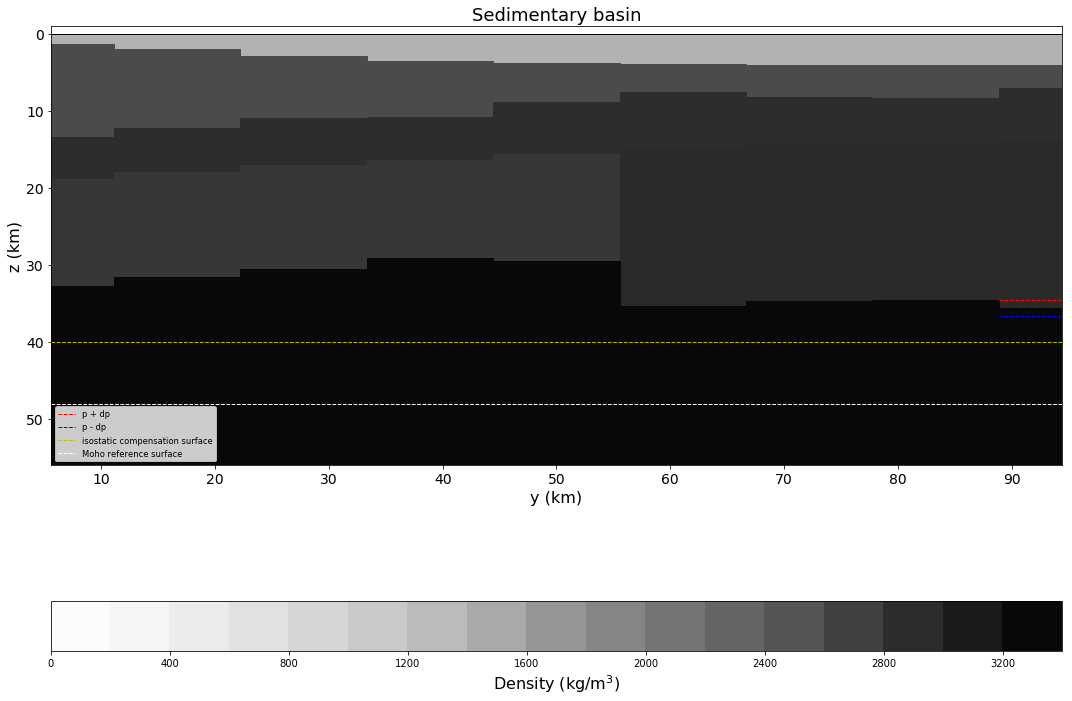

In [31]:
%matplotlib inline
G2 = fc.G_matrix_function_all(xmax,xmin,dy,edge,1000.,1000.,S0,dw,ds,dm,dcc,dc,tw,ptrue,yc,area,17,ts0,two_layers=True)

## Compara dois metodos de calculo da matriz sensibilidade

In [33]:
assert_array_almost_equal(G1, G2, decimal=3)

### Teste Mediana